In [1]:
import numpy as np
from sklearn.preprocessing import normalize as sklearn_normalize
from scipy.sparse import isspmatrix, dok_matrix, csc_matrix
import networkx as nx
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import logging
import time

In [13]:

def edge_list_to_adjacency_matrix(file_path):
    """
    Convert an edge list from a text file to an adjacency matrix.
    
    Args:
        file_path (str): Path to the file containing the edge list. 
                         Each line should have 'source target weight'.
    
    Returns:
        tuple: (adj_matrix, node_list)
               adj_matrix: numpy array representing the adjacency matrix.
               node_list: list of node IDs corresponding to the rows/columns of the matrix.
    """
    # Parse the edge list file to find all unique nodes
    nodes = set()
    edges = []
    print(file_path)
    
    with open(file_path, 'r') as f:
        for line in f:
            src, tgt, weight = map(float, line.split())
            nodes.add(int(src))
            nodes.add(int(tgt))
            edges.append((int(src), int(tgt), weight))
    
    # Create a mapping of node IDs to indices
    node_list = sorted(nodes)  # Ensure consistent ordering
    node_to_index = {node: idx for idx, node in enumerate(node_list)}
    
    # Initialize an adjacency matrix
    n = len(node_list)
    adj_matrix = np.zeros((n, n))
    
    # Fill the adjacency matrix
    for src, tgt, weight in edges:
        i, j = node_to_index[src], node_to_index[tgt]
        adj_matrix[i, j] = weight
        adj_matrix[j, i] = weight  # Uncomment if the graph is undirected
    
    return adj_matrix, node_list


In [3]:

def normalize(M):
    return sklearn_normalize(M, norm="l1", axis=0)


In [4]:
def extract_clusters(M, output_file="clusters.txt", plot_heatmap=True):
    """
    Extract clusters from the final MCL matrix by identifying attractors (diagonal non-zero entries),
    plot a heatmap, and write clusters to a text file.

    Args:
        M (numpy.ndarray): Final MCL matrix.
        output_file (str): Path to the output file where clusters will be written.
        plot_heatmap (bool): Whether to plot a heatmap of the matrix.

    Returns:
        None
    """
    diagonal = np.diag(M)
    print("Diagonal values of the matrix:", diagonal)

    # Plot the matrix as a heatmap if requested
    if plot_heatmap:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 8))
        plt.title("Heatmap of Final MCL Matrix")
        plt.imshow(M, cmap="gray_r", interpolation="nearest")
        plt.colorbar(label="Matrix Values")
        plt.xlabel("Nodes")
        plt.ylabel("Nodes")
        plt.savefig("mcl_matrix_heatmap.png")
        plt.show()

    # Step 1: Identify attractors (non-zero diagonal entries)
    attractors = np.where(np.diag(M) > 1e-5)[0]  # Indices of attractors
    clusters = {attractor: [] for attractor in attractors}

    # Step 2: Assign nodes to attractors
    for i in range(M.shape[0]):
        # Find the attractor to which this node is most strongly connected
        strongest_attractor = np.argmax(M[i, attractors])
        if M[i, attractors[strongest_attractor]] > 1e-5:  # Only assign if significant flow
            clusters[attractors[strongest_attractor]].append(i)

    # Step 3: Write clusters to the file
    with open(output_file, "w") as f:
        for cluster_nodes in clusters.values():
            cluster_str = " ".join(map(str, sorted(cluster_nodes)))
            f.write(f"{cluster_str}\n")

    print(f"Clusters written to {output_file}")
    print("Heatmap saved as 'mcl_matrix_heatmap.png'")


In [21]:
def plot_histogram(matrix, iteration):
    """Plot and save a histogram of matrix values."""
    if isspmatrix(matrix):
        values = matrix.data
    else:
        values = matrix.flatten()
    
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=50, color='blue', alpha=0.7)
    plt.title(f"Histogram of Matrix Values - Iteration {iteration}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.savefig(f"histogram_iteration_{iteration}.png")
    plt.show()

In [22]:


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def mcl(file_path, inflation, max_iter=10, epsilon=1e-2):
    """
    Perform Markov Clustering (MCL) on a graph represented by an edge list file.

    Args:
        file_path (str): Path to the file containing the edge list.
        inflation (float): Inflation parameter for the MCL algorithm.
        max_iter (int): Maximum number of iterations to perform.
        epsilon (float): Convergence threshold for the Frobenius norm.

    Returns:
        numpy.ndarray: The final matrix after MCL processing.
    """
    logging.info("Starting MCL algorithm")
    # Convert to adjacency matrix
    M, _ = edge_list_to_adjacency_matrix(file_path)

    # Into numpy
    M = np.array(M, dtype=float)
    # Initialization
    M = normalize(M)
    logging.info("Normalized initial matrix:\n%s", M)

    convergence = False
    previous_M = M
    i = 0
    total_time = 0  # To keep track of total time across all iterations

    while i < max_iter and not convergence:
        logging.info("Iteration %d started", i + 1)
        iteration_start_time = time.time()

        # Plot histogram before iteration
        plot_histogram(M, i)

        # Expansion
        expansion_start_time = time.time()
        M = np.matmul(M, M)
        expansion_time = time.time() - expansion_start_time
        logging.debug("After expansion:\n%s", M)
        logging.info("Iteration %d: Expansion took %.6f seconds", i + 1, expansion_time)

        # Inflation
        inflation_start_time = time.time()
        M = np.power(M, inflation)
        M = normalize(M)
        inflation_time = time.time() - inflation_start_time
        logging.debug("After inflation:\n%s", M)
        logging.info("Iteration %d: Inflation took %.6f seconds", i + 1, inflation_time)

        # Check convergence using Frobenius norm
        diff_norm = np.linalg.norm(previous_M - M)
        logging.info("Iteration %d: Frobenius norm difference = %.6f", i + 1, diff_norm)

        convergence = diff_norm < epsilon
        if convergence:
            logging.info("Convergence achieved at iteration %d", i + 1)

        previous_M = M
        iteration_end_time = time.time()
        iteration_time = iteration_end_time - iteration_start_time
        total_time += iteration_time
        logging.info("Iteration %d: Total iteration time = %.6f seconds", i + 1, iteration_time)

        i += 1

    # Log total time
    logging.info("Total time for MCL processing: %.6f seconds", total_time)

    # Log final matrix
    logging.info("Final matrix:\n%s", M)

    return M


2024-12-15 18:55:05,625 - INFO - Starting MCL algorithm


/Users/Andrej/Documents/MVA/PGM/Wikipedia-Clustering/crocodile_graph.txt


2024-12-15 18:55:07,376 - INFO - Normalized initial matrix:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02173913 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
2024-12-15 18:55:07,380 - INFO - Iteration 1 started


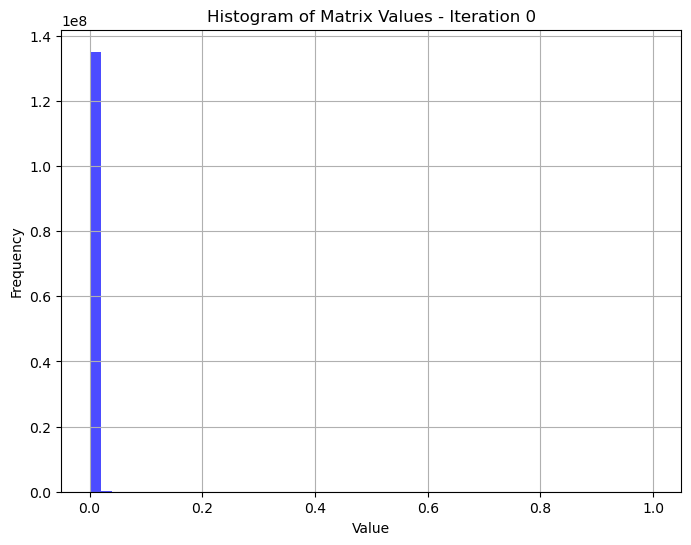

2024-12-15 18:55:32,889 - INFO - Iteration 1: Expansion took 23.817856 seconds
2024-12-15 18:55:36,395 - INFO - Iteration 1: Inflation took 3.480670 seconds
2024-12-15 18:55:37,471 - INFO - Iteration 1: Frobenius norm difference = 45.865345
2024-12-15 18:55:37,477 - INFO - Iteration 1: Total iteration time = 30.096739 seconds
2024-12-15 18:55:37,478 - INFO - Iteration 2 started


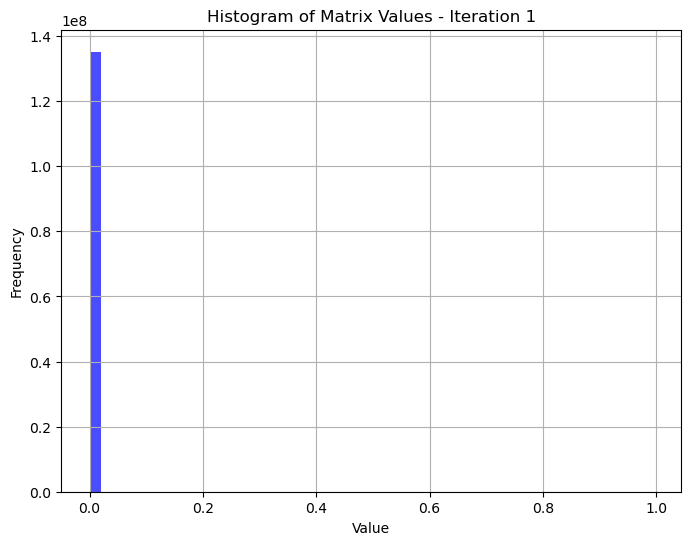

2024-12-15 18:56:02,831 - INFO - Iteration 2: Expansion took 23.647845 seconds
2024-12-15 18:56:06,723 - INFO - Iteration 2: Inflation took 3.853564 seconds
2024-12-15 18:56:08,579 - INFO - Iteration 2: Frobenius norm difference = 10.791029
2024-12-15 18:56:08,613 - INFO - Iteration 2: Total iteration time = 31.134573 seconds
2024-12-15 18:56:08,620 - INFO - Iteration 3 started


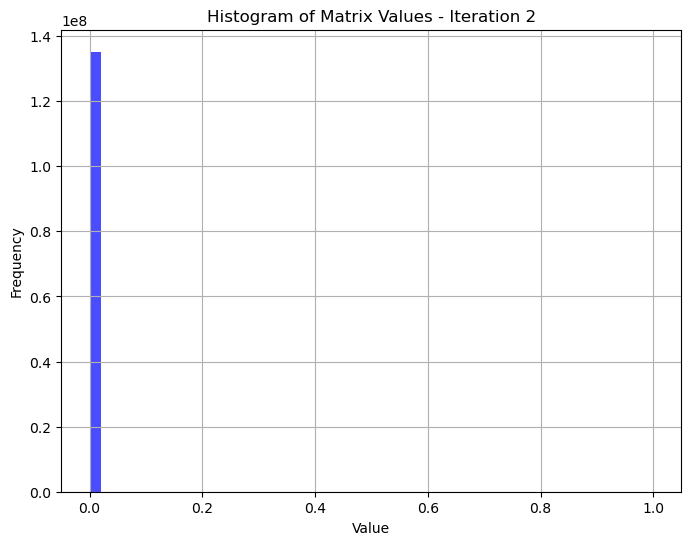

2024-12-15 18:56:30,792 - INFO - Iteration 3: Expansion took 19.401593 seconds
2024-12-15 18:56:34,320 - INFO - Iteration 3: Inflation took 3.521594 seconds
2024-12-15 18:56:35,756 - INFO - Iteration 3: Frobenius norm difference = 19.689132
2024-12-15 18:56:35,764 - INFO - Iteration 3: Total iteration time = 27.141827 seconds
2024-12-15 18:56:35,766 - INFO - Iteration 4 started


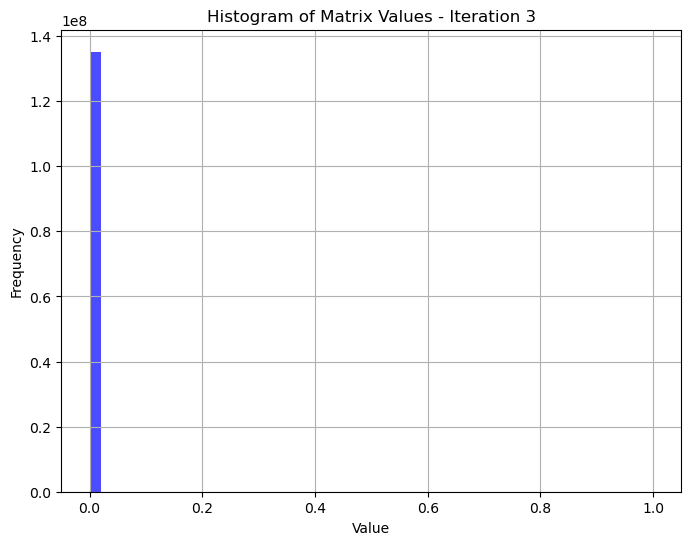

2024-12-15 18:56:55,765 - INFO - Iteration 4: Expansion took 18.816195 seconds
2024-12-15 18:56:59,884 - INFO - Iteration 4: Inflation took 4.018428 seconds
2024-12-15 18:57:03,091 - INFO - Iteration 4: Frobenius norm difference = 27.640476
2024-12-15 18:57:03,123 - INFO - Iteration 4: Total iteration time = 27.355417 seconds
2024-12-15 18:57:03,123 - INFO - Iteration 5 started


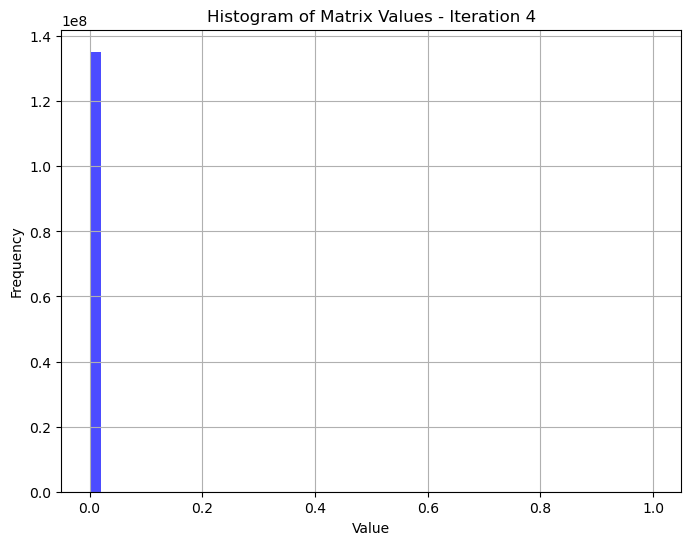

2024-12-15 18:57:27,550 - INFO - Iteration 5: Expansion took 23.032329 seconds
2024-12-15 18:57:31,198 - INFO - Iteration 5: Inflation took 3.625852 seconds
2024-12-15 18:57:33,250 - INFO - Iteration 5: Frobenius norm difference = 29.406738
2024-12-15 18:57:33,264 - INFO - Iteration 5: Total iteration time = 30.139127 seconds
2024-12-15 18:57:33,268 - INFO - Iteration 6 started


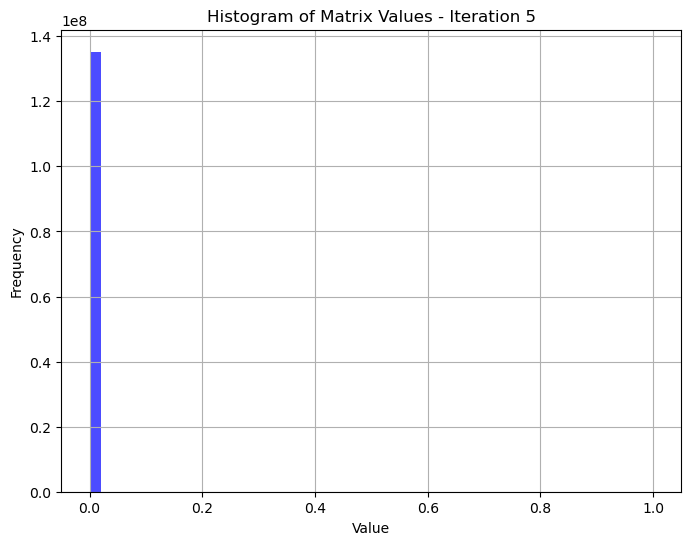

2024-12-15 18:58:05,812 - INFO - Iteration 6: Expansion took 31.150149 seconds
2024-12-15 18:58:09,850 - INFO - Iteration 6: Inflation took 3.962327 seconds
2024-12-15 18:58:13,351 - INFO - Iteration 6: Frobenius norm difference = 25.452228
2024-12-15 18:58:13,371 - INFO - Iteration 6: Total iteration time = 40.102501 seconds
2024-12-15 18:58:13,372 - INFO - Iteration 7 started


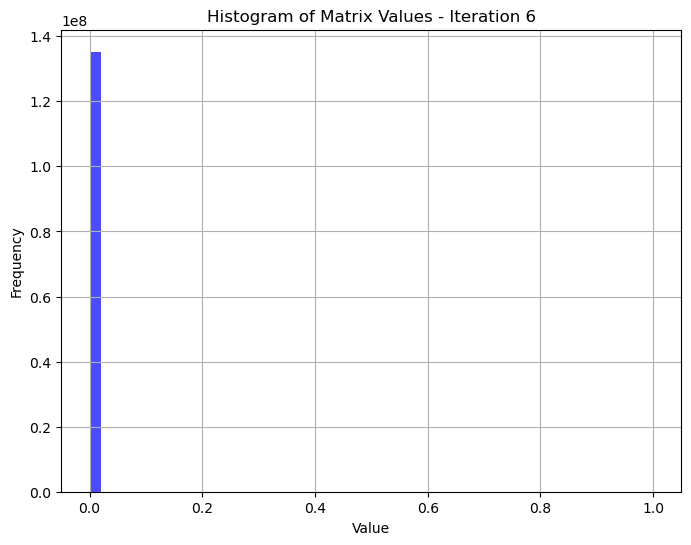

2024-12-15 18:58:43,630 - INFO - Iteration 7: Expansion took 28.798338 seconds
2024-12-15 18:58:48,753 - INFO - Iteration 7: Inflation took 5.079230 seconds
2024-12-15 18:58:52,026 - INFO - Iteration 7: Frobenius norm difference = 20.217284
2024-12-15 18:58:52,039 - INFO - Iteration 7: Total iteration time = 38.666692 seconds
2024-12-15 18:58:52,041 - INFO - Iteration 8 started


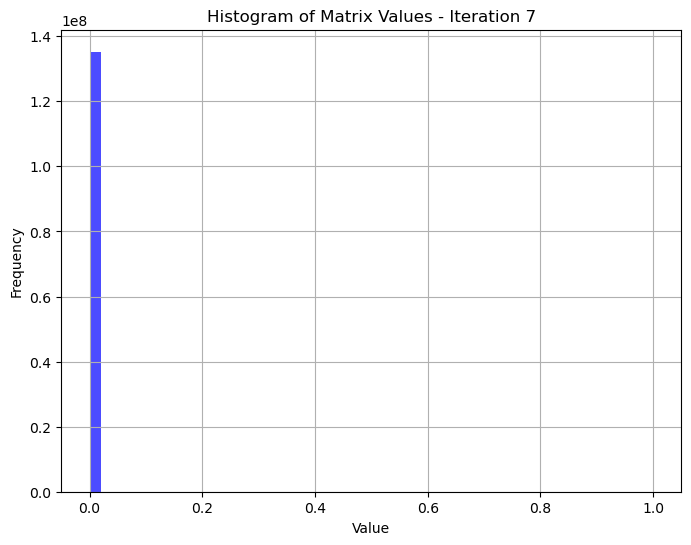

2024-12-15 18:59:18,688 - INFO - Iteration 8: Expansion took 25.051782 seconds
2024-12-15 18:59:23,058 - INFO - Iteration 8: Inflation took 4.348995 seconds
2024-12-15 18:59:26,911 - INFO - Iteration 8: Frobenius norm difference = 15.449275
2024-12-15 18:59:26,992 - INFO - Iteration 8: Total iteration time = 34.949995 seconds
2024-12-15 18:59:26,994 - INFO - Iteration 9 started


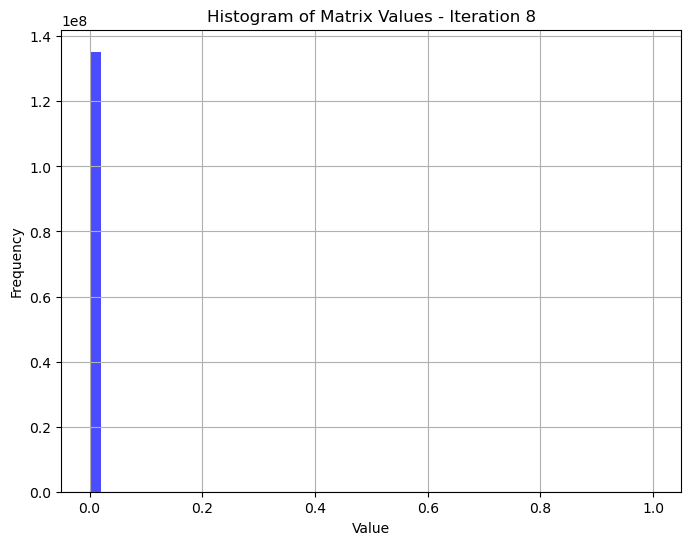

2024-12-15 18:59:56,945 - INFO - Iteration 9: Expansion took 27.936902 seconds
2024-12-15 19:00:00,934 - INFO - Iteration 9: Inflation took 3.931730 seconds
2024-12-15 19:00:03,689 - INFO - Iteration 9: Frobenius norm difference = 13.651334
2024-12-15 19:00:03,699 - INFO - Iteration 9: Total iteration time = 36.700143 seconds
2024-12-15 19:00:03,700 - INFO - Iteration 10 started


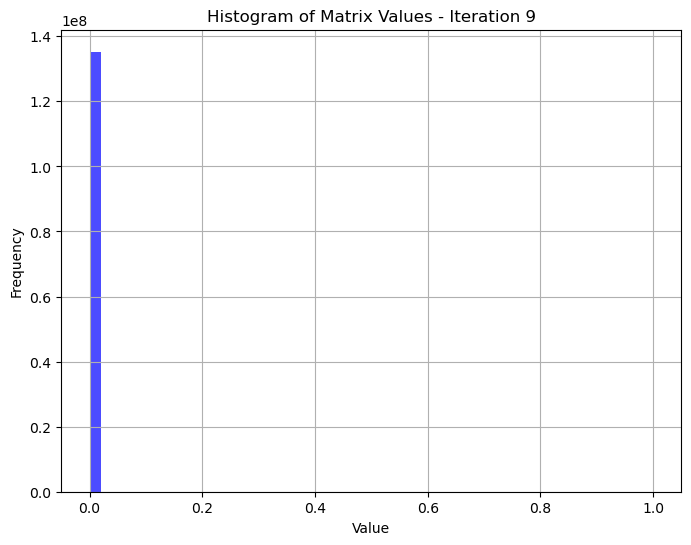

2024-12-15 19:00:41,595 - INFO - Iteration 10: Expansion took 35.784522 seconds
2024-12-15 19:00:45,974 - INFO - Iteration 10: Inflation took 4.343462 seconds
2024-12-15 19:00:50,436 - INFO - Iteration 10: Frobenius norm difference = 9.215841
2024-12-15 19:00:50,611 - INFO - Iteration 10: Total iteration time = 46.908763 seconds
2024-12-15 19:00:50,615 - INFO - Iteration 11 started


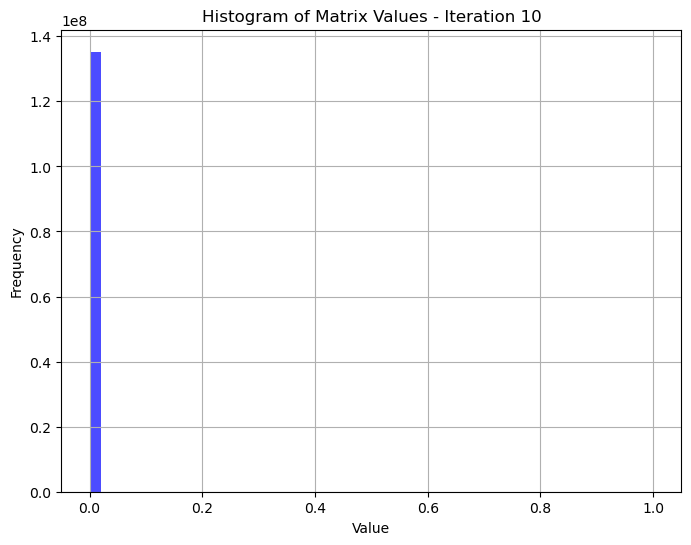

In [17]:

# adjacency = [
#     [1, 1, 0, 0],
#     [1, 1, 1, 0],
#     [0, 1, 1, 1],
#     [0, 0, 1, 1],
# ]

# result = mcl(adjacency, inflation=2.0)
result = mcl(file_path="/Users/Andrej/Documents/MVA/PGM/Wikipedia-Clustering/crocodile_graph.txt", inflation=1.5, max_iter=100, epsilon=1e-3)
print("Clusters:")
print(extract_clusters(result))

In [68]:
def get_clusters(matrix):
    """
    Retrieve the clusters from the matrix
    
    :param matrix: The matrix produced by the MCL algorithm
    :returns: A list of tuples where each tuple represents a cluster and
              contains the indices of the nodes belonging to the cluster
    """
    # # plotting the heatmap
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(10, 8))
    # plt.title("Heatmap of Final MCL Matrix")
    # plt.imshow(matrix, cmap="gray_r", interpolation="nearest")
    # plt.colorbar(label="Matrix Values")
    # plt.xlabel("Nodes")
    # plt.ylabel("Nodes")
    # plt.savefig("mcl_matrix_heatmap.png")
    # plt.show()
    
    print("Matrix diagonal:", matrix.diagonal())

    # get the attractors - non-zero elements of the matrix diagonal
    attractors = matrix.diagonal().nonzero()[0]
    print("Attractors:", attractors)

    # somewhere to put the clusters
    clusters = set()

    # the nodes in the same row as each attractor form a cluster
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters))

Clusters:


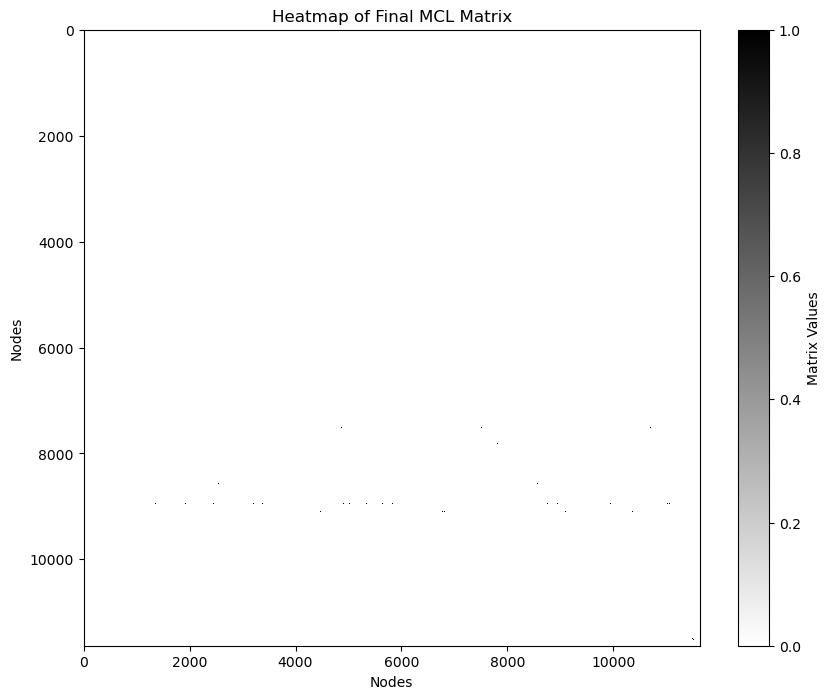

[(0, 2, 8, 12, 17, 22, 26, 28, 30, 32, 33, 35, 37, 45, 46, 49, 50, 53, 57, 64, 66, 71, 73, 74, 75, 76, 78, 82, 87, 88, 92, 95, 100, 103, 108, 110, 112, 113, 117, 120, 127, 128, 136, 139, 140, 141, 143, 144, 145, 146, 150, 155, 159, 160, 163, 165, 168, 170, 174, 179, 181, 183, 186, 191, 193, 196, 201, 208, 209, 210, 212, 213, 218, 219, 220, 222, 229, 234, 236, 238, 240, 244, 251, 255, 257, 259, 265, 268, 269, 270, 271, 272, 274, 277, 279, 280, 285, 291, 298, 303, 306, 311, 313, 318, 323, 324, 332, 335, 337, 340, 341, 343, 344, 345, 347, 351, 353, 360, 369, 374, 377, 378, 381, 382, 384, 392, 405, 408, 409, 410, 411, 412, 417, 420, 427, 435, 436, 439, 443, 445, 446, 448, 452, 455, 457, 459, 462, 463, 465, 467, 471, 474, 477, 478, 485, 486, 488, 490, 493, 495, 498, 501, 511, 512, 513, 515, 519, 521, 530, 531, 534, 535, 539, 545, 549, 550, 552, 556, 557, 558, 559, 563, 565, 568, 575, 576, 584, 586, 590, 599, 601, 608, 610, 613, 614, 619, 620, 623, 629, 630, 637, 639, 641, 643, 646, 649, 652

In [19]:
print("Clusters:")
clusters = get_clusters(result)
with open("clusters_test_2.txt", "w") as f:
    for cluster in clusters:
        f.write(" ".join(map(str, cluster)) + "\n")
print(clusters)

Nombre de nœuds : 1791489
Nombre d'arêtes : 25447873


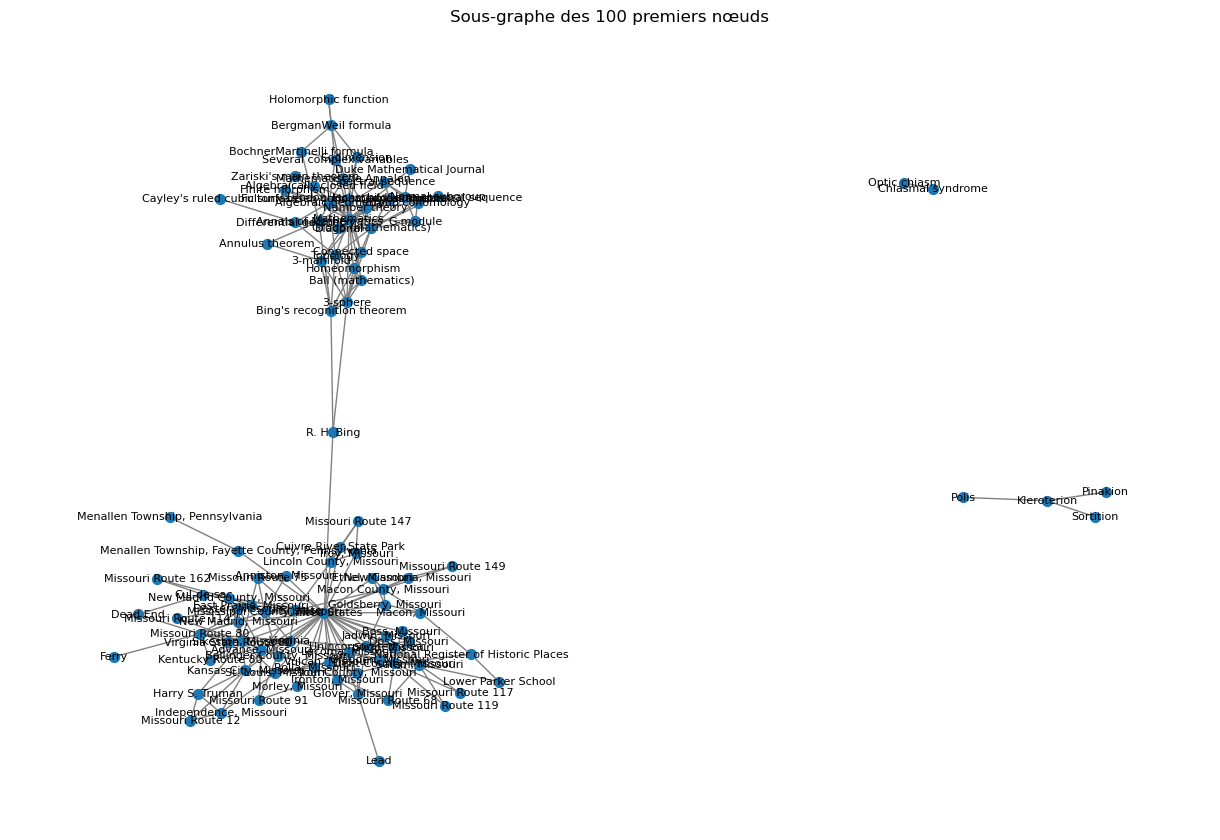

In [ ]:
import gzip


# Charger les arêtes du graphe
def load_edges(file_path):
    edges = []
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            source, target = map(int, line.strip().split())
            edges.append((source, target))
    return edges

# Charger les noms des pages
def load_page_names(file_path):
    page_names = {}
    with gzip.open(file_path, 'rt') as f:  # Ouvrir en mode texte
        for line in f:
            line = line.strip()
            if not line:  # Ignorer les lignes vides
                continue
            parts = line.split(' ', 1)
            if len(parts) == 2:  # Vérifier que la ligne contient bien deux parties
                page_id, page_name = parts
                page_names[int(page_id)] = page_name
    return page_names

# Chemins vers les fichiers
base_path = "data/big_graph"
edges_file = f"{base_path}/wiki-topcats.txt.gz"
page_names_file = f"{base_path}/wiki-topcats-page-names.txt.gz"

# Charger les données
edges = load_edges(edges_file)
page_names = load_page_names(page_names_file)

# Créer le graphe
G = nx.Graph()
G.add_edges_from(edges)  # Ajouter les arêtes

# Ajouter les noms des pages comme attributs des nœuds
nx.set_node_attributes(G, page_names, "name")

# Informations sur le graphe
print(f"Nombre de nœuds : {G.number_of_nodes()}")
print(f"Nombre d'arêtes : {G.number_of_edges()}")

# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:100])  # Prenez un sous-graphe avec 100 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation
plt.figure(figsize=(12, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    labels={node: G.nodes[node]["name"] for node in subgraph.nodes},  # Utiliser les noms des pages
    node_size=50,
    font_size=8,
    edge_color="gray",
)
plt.title("Sous-graphe des 100 premiers nœuds")
plt.show()

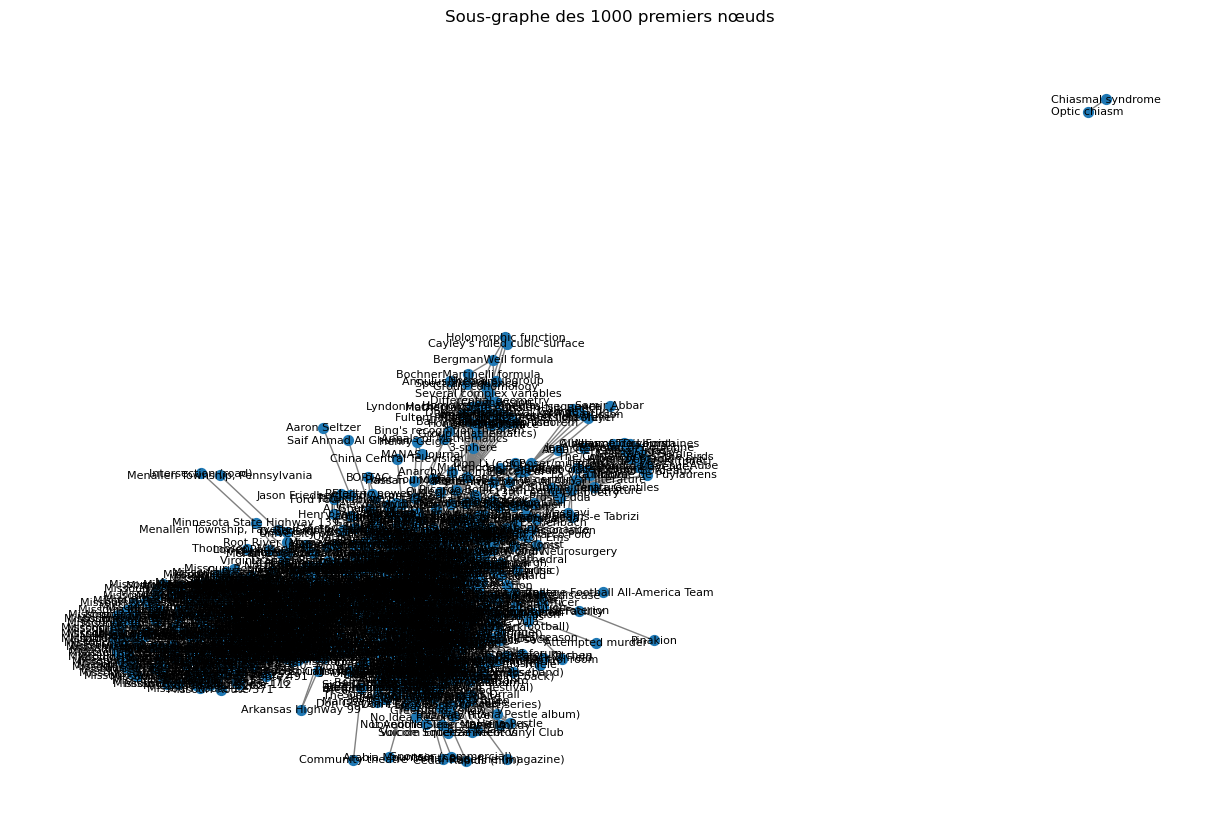

In [52]:
# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:1000])  # Prenez un sous-graphe avec 100 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation
plt.figure(figsize=(12, 8))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    labels={node: G.nodes[node]["name"] for node in subgraph.nodes},  # Utiliser les noms des pages
    node_size=50,
    font_size=8,
    edge_color="gray",
)
plt.title("Sous-graphe des 1000 premiers nœuds")
plt.show()

In [53]:
import networkx as nx
import numpy as np

# enumerate the nodes in the graph
subgraph_node_list = list(subgraph.nodes())
print(f"Number of nodes: {len(subgraph_node_list)}")
print(f"Node List: {subgraph_node_list}")

# number of edges in the subgraph
print(f"Number of edges: {subgraph.number_of_edges()}")


# Convert the graph to a dense adjacency matrix
adj_matrix = nx.adjacency_matrix(subgraph).toarray()

# Save the adjacency matrix to a file (optional)
np.save("adj_matrix.npy", adj_matrix)

# Print the shape of the adjacency matrix
print(f"Adjacency Matrix Shape: {adj_matrix.shape}")

with open("subgraph_edge_list.txt", 'w') as f:
        for edge in subgraph.edges():
            f.write(f"{edge[0]} {edge[1]} 1.0\n")

Number of nodes: 1000
Node List: [0, 1, 2, 3, 1101827, 1101828, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 20, 26, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 1069112, 54, 55, 56, 278588, 57, 58, 59, 60, 61, 62, 63, 64, 65, 1101894, 66, 67, 68, 69, 70, 1189964, 327757, 71, 72, 73, 81, 82, 280657, 84, 290900, 77, 78, 79, 292953, 83, 85, 1181788, 86, 87, 88, 89, 90, 91, 1214563, 1101924, 92, 93, 94, 1777768, 96, 1056874, 98, 1409132, 100, 101, 102, 239728, 107, 105, 106, 109, 57461, 110, 111, 113, 1101945, 114, 115, 116, 117, 1169534, 118, 119, 120, 121, 122, 123, 124, 1486982, 612486, 1489032, 1177736, 694410, 1577098, 1489035, 639118, 1489040, 1177745, 1538194, 239763, 639126, 340125, 1218719, 745632, 1172760, 1101987, 250020, 1106090, 1777843, 65572, 205, 170193, 155862, 1296606, 280799, 194783, 8418, 1544420, 2277, 1179882, 1013995, 485611, 2288, 155888, 1179890, 1165558, 67832, 790783,

In [41]:
def save_edge_list(graph, output_file, weight=1.0):
    """
    Save a NetworkX graph to an edge list file.
    
    Parameters:
    graph (networkx.Graph): Graph object.
    output_file (str): Path to the output .txt file.
    weight (float): Arbitrary edge weight to include in the edge list.
    """
    with open(output_file, 'w') as f:
        for edge in graph.edges():
            f.write(f"{edge[0]} {edge[1]} {weight}\n")

In [42]:
save_edge_list(subgraph, "subgraph_edge_list.txt")

In [98]:
def prune(matrix, threshold):
    """
    Prunes a matrix by setting values below a threshold to 0,
    while ensuring the maximum value in each column is never set to 0.
    
    Parameters:
        matrix (numpy.ndarray): The matrix to prune.
        threshold (float): The threshold below which values are set to 0.

    Returns:
        numpy.ndarray: The pruned matrix.
    """
    # Create a true deep copy of the matrix
    pruned_matrix = np.zeros(matrix.shape)
    print(pruned_matrix.shape)
    
    # Find the indices of the maximum values in each column
    max_indices = np.argmax(matrix, axis=0)
    print(max_indices)
    
    # Create a mask for values below the threshold
    mask = matrix >= threshold
    print(type(mask))

    pruned_matrix[mask] = matrix[mask]  # Keep values above the threshold
    
    # Ensure maximum values in each column are not set to 0
    for col, row in enumerate(max_indices):
        pruned_matrix[row, col] = matrix[row, col]  # Restore original max value if it was set to 0
    
    return pruned_matrix

In [2]:
import numpy as np
import scipy.sparse as sp
import time
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def normalize(matrix):
    """
    Normalize a sparse matrix so that each column sums to 1.
    """
    column_sums = np.array(matrix.sum(axis=0)).flatten()
    nonzero_columns = column_sums > 0
    column_sums[~nonzero_columns] = 1  # Avoid division by zero
    inv_column_sums = 1.0 / column_sums
    D_inv = sp.diags(inv_column_sums)
    return matrix @ D_inv

def mcl(matrix, inflation, max_iter=10, self_loop=1, prunning_threshold=0.001, epsilon=1e-2):
    """
    Perform Markov Clustering (MCL) on a graph represented as a sparse matrix.

    Args:
        matrix (scipy.sparse.csr_matrix): Sparse adjacency matrix.
        inflation (float): Inflation parameter for the MCL algorithm.
        max_iter (int): Maximum number of iterations to perform.
        epsilon (float): Convergence threshold for the Frobenius norm.

    Returns:
        scipy.sparse.csr_matrix: The final matrix after MCL processing.
    """
    logging.info("Starting MCL algorithm")

    # Ensure the matrix is in CSR format for efficient operations
    # M = sp.csr_matrix(matrix, dtype=float)
    M = matrix.copy()
    # Initialization
    M = normalize(M)
    logging.info("Normalized initial matrix")

    if self_loop > 0:
        # Add self-loops to the matrix
        logging.info("Adding self-loops with p = %d", self_loop)
        M = M + self_loop * sp.eye(M.shape[0])

    convergence = False
    previous_M = M.copy()
    i = 0
    total_time = 0  # To keep track of total time across all iterations

    while i < max_iter and not convergence:
        logging.info("Iteration %d started", i + 1)
        iteration_start_time = time.time()

        # Expansion
        expansion_start_time = time.time()
        M = M @ M
        expansion_time = time.time() - expansion_start_time
        logging.info("Iteration %d: Expansion took %.6f seconds", i + 1, expansion_time)

        # Inflation
        inflation_start_time = time.time()
        M.data = np.power(M.data, inflation)  # Apply inflation to non-zero elements
        M = normalize(M)
        inflation_time = time.time() - inflation_start_time
        logging.info("Iteration %d: Inflation took %.6f seconds", i + 1, inflation_time)

        # Check convergence using Frobenius norm
        diff = M - previous_M
        diff_norm = sp.linalg.norm(diff)
        logging.info("Iteration %d: Frobenius norm difference = %.6f", i + 1, diff_norm)

        # Prunning
        if prunning_threshold > 0:
            M = prune(M, prunning_threshold)

        convergence = diff_norm < epsilon
        if convergence:
            logging.info("Convergence achieved at iteration %d", i + 1)

        previous_M = M.copy()
        iteration_end_time = time.time()
        iteration_time = iteration_end_time - iteration_start_time
        total_time += iteration_time
        logging.info("Iteration %d: Total iteration time = %.6f seconds", i + 1, iteration_time)

        i += 1

    # Log total time
    logging.info("Total time for MCL processing: %.6f seconds", total_time)

    # Log final matrix
    logging.info("Final matrix computed")

    return M

In [ ]:
# running the algo with differen inflation values
# inflation_values = [1.1, 1.3, 1.5, 2.0]
inflation_values = [1.5]
final_matrices = {}
for inflation in inflation_values:
    logging.info("Running MCL with inflation = %.2f", inflation)
    final_matrix = mcl(adj_matrix_sparse, inflation=inflation, max_iter=100, epsilon=1e-6)
    final_matrices[inflation] = final_matrix


In [ ]:

# Extract clusters for each inflation value
clusters = {}
for inflation, matrix in final_matrices.items():
    logging.info("Extracting clusters for inflation = %.2f", inflation)
    clusters[inflation] = get_clusters(matrix)

# Save the clusters to files
for inflation, cluster_ids in clusters.items():
    with open(f"clusters_inflation_{inflation}.txt", "w") as f:
        for cluster in cluster_ids:
            f.write(" ".join(map(str, cluster)) + "\n")

            

In [64]:
# transforming cluters to a list of sets
cluster_sets = {inflation: [set(cluster) for cluster in clusters] for inflation, clusters in clusters.items()}

In [65]:
clusters = cluster_sets[1.5]

# Total node range
all_nodes = set(range(1000))  # Adjust based on your actual node range

# Flatten clusters into a single set
nodes_in_clusters = set().union(*clusters)

# Check completeness
if nodes_in_clusters != all_nodes:
    missing_nodes = all_nodes - nodes_in_clusters
    extra_nodes = nodes_in_clusters - all_nodes
    print(f"Missing nodes: {missing_nodes}")
    print(f"Extra nodes: {extra_nodes}")
else:
    print("All nodes are included.")

# Check uniqueness
total_nodes_in_clusters = sum(len(cluster) for cluster in clusters)
if len(nodes_in_clusters) != total_nodes_in_clusters:
    print("Some nodes are duplicated across clusters.")
else:
    print("All nodes are unique across clusters.")

All nodes are included.
Some nodes are duplicated across clusters.


In [8]:
import numpy as np
from scipy.sparse import isspmatrix, dok_matrix, csc_matrix
import sklearn.preprocessing
from utils import MessagePrinter
import time


def sparse_allclose(a, b, rtol=1e-5, atol=1e-8):
    """
    Version of np.allclose for use with sparse matrices
    """
    c = np.abs(a - b) - rtol * np.abs(b)
    # noinspection PyUnresolvedReferences
    return c.max() <= atol


def normalize(matrix):
    """
    Normalize the columns of the given matrix
    
    :param matrix: The matrix to be normalized
    :returns: The normalized matrix
    """
    return sklearn.preprocessing.normalize(matrix, norm="l1", axis=0)


def inflate(matrix, power):
    """
    Apply cluster inflation to the given matrix by raising
    each element to the given power.
    
    :param matrix: The matrix to be inflated
    :param power: Cluster inflation parameter
    :returns: The inflated matrix
    """
    if isspmatrix(matrix):
        return normalize(matrix.power(power))

    return normalize(np.power(matrix, power))


def expand(matrix, power):
    """
    Apply cluster expansion to the given matrix by raising
    the matrix to the given power.
    
    :param matrix: The matrix to be expanded
    :param power: Cluster expansion parameter
    :returns: The expanded matrix
    """
    if isspmatrix(matrix):
        return matrix ** power

    return np.linalg.matrix_power(matrix, power)


def add_self_loops(matrix, loop_value):
    """
    Add self-loops to the matrix by setting the diagonal
    to loop_value
    
    :param matrix: The matrix to add loops to
    :param loop_value: Value to use for self-loops
    :returns: The matrix with self-loops
    """
    shape = matrix.shape
    assert shape[0] == shape[1], "Error, matrix is not square"

    if isspmatrix(matrix):
        new_matrix = matrix.todok()
    else:
        new_matrix = matrix.copy()

    for i in range(shape[0]):
        new_matrix[i, i] = loop_value

    if isspmatrix(matrix):
        return new_matrix.tocsc()

    return new_matrix


def prune(matrix, threshold):
    """
    Prune the matrix so that very small edges are removed.
    The maximum value in each column is never pruned.
    
    :param matrix: The matrix to be pruned
    :param threshold: The value below which edges will be removed
    :returns: The pruned matrix
    """
    if isspmatrix(matrix):
        pruned = dok_matrix(matrix.shape)
        pruned[matrix >= threshold] = matrix[matrix >= threshold]
        pruned = pruned.tocsc()
    else:
        pruned = matrix.copy()
        pruned[pruned < threshold] = 0

    # keep max value in each column. same behaviour for dense/sparse
    num_cols = matrix.shape[1]
    row_indices = matrix.argmax(axis=0).reshape((num_cols,))
    col_indices = np.arange(num_cols)
    pruned[row_indices, col_indices] = matrix[row_indices, col_indices]

    return pruned


def converged(matrix1, matrix2):
    """
    Check for convergence by determining if 
    matrix1 and matrix2 are approximately equal.
    
    :param matrix1: The matrix to compare with matrix2
    :param matrix2: The matrix to compare with matrix1
    :returns: True if matrix1 and matrix2 approximately equal
    """
    if isspmatrix(matrix1) or isspmatrix(matrix2):
        return sparse_allclose(matrix1, matrix2)

    convergence = np.allclose(matrix1, matrix2)
    print("Convergence: ", np.linalg.norm(matrix1 - matrix2))
    return convergence


def iterate(matrix, expansion, inflation):
    """
    Run a single iteration (expansion + inflation) of the mcl algorithm
    
    :param matrix: The matrix to perform the iteration on
    :param expansion: Cluster expansion factor
    :param inflation: Cluster inflation factor
    """
    # Expansion
    matrix = expand(matrix, expansion)

    # Inflation
    matrix = inflate(matrix, inflation)

    return matrix


def get_clusters(matrix):
    """
    Retrieve the clusters from the matrix
    
    :param matrix: The matrix produced by the MCL algorithm
    :returns: A list of tuples where each tuple represents a cluster and
              contains the indices of the nodes belonging to the cluster
    """
    # plotting the heatmap
    # import seaborn as sns
    
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(10, 8))
    # plt.title("Heatmap of Final MCL Matrix")
    # plt.imshow(matrix, cmap="gray_r", interpolation="nearest")
    # plt.colorbar(label="Matrix Values")
    # plt.xlabel("Nodes")
    # plt.ylabel("Nodes")
    # plt.savefig("mcl_matrix_heatmap.png")
    # plt.show()

    if not isspmatrix(matrix):
        # cast to sparse so that we don't need to handle different 
        # matrix types
        matrix = csc_matrix(matrix)

    print("here")
    # get the attractors - non-zero elements of the matrix diagonal
    attractors = matrix.diagonal().nonzero()[0]
    print("attractors", attractors)
    # somewhere to put the clusters
    clusters = set()
    print("matrix")

    # the nodes in the same row as each attractor form a cluster
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters))


def run_mcl(matrix, expansion=2, inflation=2, loop_value=1,
            iterations=100, pruning_threshold=0.001, pruning_frequency=1,
            convergence_check_frequency=1, verbose=False):
    """
    Perform MCL on the given similarity matrix
    
    :param matrix: The similarity matrix to cluster
    :param expansion: The cluster expansion factor
    :param inflation: The cluster inflation factor
    :param loop_value: Initialization value for self-loops
    :param iterations: Maximum number of iterations
           (actual number of iterations will be less if convergence is reached)
    :param pruning_threshold: Threshold below which matrix elements will be set
           set to 0
    :param pruning_frequency: Perform pruning every 'pruning_frequency'
           iterations. 
    :param convergence_check_frequency: Perform the check for convergence
           every convergence_check_frequency iterations
    :param verbose: Print extra information to the console
    :returns: The final matrix
    """
    assert expansion > 1, "Invalid expansion parameter"
    assert inflation > 1, "Invalid inflation parameter"
    assert loop_value >= 0, "Invalid loop_value"
    assert iterations > 0, "Invalid number of iterations"
    assert pruning_threshold >= 0, "Invalid pruning_threshold"
    assert pruning_frequency > 0, "Invalid pruning_frequency"
    assert convergence_check_frequency > 0, "Invalid convergence_check_frequency"

    printer = MessagePrinter(verbose)

    printer.print("-" * 50)
    printer.print("MCL Parameters")
    printer.print("Expansion: {}".format(expansion))
    printer.print("Inflation: {}".format(inflation))
    if pruning_threshold > 0:
        printer.print("Pruning threshold: {}, frequency: {} iteration{}".format(
            pruning_threshold, pruning_frequency, "s" if pruning_frequency > 1 else ""))
    else:
        printer.print("No pruning")
    printer.print("Convergence check: {} iteration{}".format(
        convergence_check_frequency, "s" if convergence_check_frequency > 1 else ""))
    printer.print("Maximum iterations: {}".format(iterations))
    printer.print("{} matrix mode".format("Sparse" if isspmatrix(matrix) else "Dense"))
    printer.print("-" * 50)

    # Initialize self-loops
    if loop_value > 0:
        matrix = add_self_loops(matrix, loop_value)

    # Normalize
    matrix = normalize(matrix)

    # iterations
    for i in range(iterations):
        print("Iteration {}".format(i + 1))

        # store current matrix for convergence checking
        last_mat = matrix.copy()

        start_time = time.time()
        
        # perform MCL expansion and inflation
        matrix = iterate(matrix, expansion, inflation)
        
        end_time = time.time()
        printer.print("Iteration time: {:.4f} seconds".format(end_time - start_time))

        # prune
        if pruning_threshold > 0 and i % pruning_frequency == pruning_frequency - 1:
            printer.print("Pruning")
            matrix = prune(matrix, pruning_threshold)

        # Check for convergence
        if i % convergence_check_frequency == convergence_check_frequency - 1:
            printer.print("Checking for convergence")
            if converged(matrix, last_mat):
                printer.print("Converged after {} iteration{}".format(i + 1, "s" if i > 0 else ""))
                break

    printer.print("-" * 50)

    return matrix

def edge_list_to_adjacency_matrix(file_path):
    """
    Convert an edge list from a text file to an adjacency matrix.
    
    Args:
        file_path (str): Path to the file containing the edge list. 
                         Each line should have 'source target weight'.
    
    Returns:
        tuple: (adj_matrix, node_list)
               adj_matrix: numpy array representing the adjacency matrix.
               node_list: list of node IDs corresponding to the rows/columns of the matrix.
    """
    # Parse the edge list file to find all unique nodes
    nodes = set()
    edges = []
    print(file_path)
    
    with open(file_path, 'r') as f:
        for line in f:
            src, tgt, weight = map(float, line.split())
            nodes.add(int(src))
            nodes.add(int(tgt))
            edges.append((int(src), int(tgt), weight))
    
    # Create a mapping of node IDs to indices
    node_list = sorted(nodes)  # Ensure consistent ordering
    node_to_index = {node: idx for idx, node in enumerate(node_list)}
    
    # Initialize an adjacency matrix
    n = len(node_list)
    adj_matrix = np.zeros((n, n))
    
    # Fill the adjacency matrix
    for src, tgt, weight in edges:
        i, j = node_to_index[src], node_to_index[tgt]
        adj_matrix[i, j] = weight
        adj_matrix[j, i] = weight  # Uncomment if the graph is undirected
    
    return adj_matrix, node_list

In [4]:
# load adjacency matrix
import numpy as np

# Specify the path to your .npy file
file_path = 'adj_matrix.npy'

# Load the 2D array
matrix = np.load(file_path)

# Print the loaded array
print(matrix)

# Check its shape to confirm it's 2D
print("Shape of the array:", matrix.shape)

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape of the array: (1000, 1000)


In [6]:
"""
Simple togglable printer class
"""


class MessagePrinter(object):
    def __init__(self, enabled):
        self._enabled = enabled

    def enable(self):
        self._enabled = True

    def disable(self):
        self._enabled = False

    def print(self, string):
        if self._enabled:
            print(string)


In [11]:
# running the algo with differen inflation values
inflation_values = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
# inflation_values = [1.5]
final_matrices = {}
print(matrix)
for inflation in inflation_values:
    print("Running MCL with inflation = %.2f", inflation)
    final_matrix = run_mcl(matrix)
    final_matrices[inflation] = final_matrix


[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Running MCL with inflation = %.2f 1.1
Iteration 1
Convergence:  8.630073022154406
Iteration 2
Convergence:  12.0501648261718
Iteration 3
Convergence:  12.32210224350849
Iteration 4
Convergence:  7.301622792180357
Iteration 5
Convergence:  4.5432161166161285
Iteration 6
Convergence:  2.609009333842036
Iteration 7
Convergence:  1.392764331610221
Iteration 8
Convergence:  0.8075513926175513
Iteration 9
Convergence:  0.6134403255789326
Iteration 10
Convergence:  0.5116870081116063
Iteration 11
Convergence:  0.39093583273875254
Iteration 12
Convergence:  0.24099077308549147
Iteration 13
Convergence:  0.28039281706941077
Iteration 14
Convergence:  0.26506438272648575
Iteration 15
Convergence:  0.0874923083290034
Iteration 16
Convergence:  0.005143662723692435
Iteration 17
Convergence:  1.1697592281651553e-05
Iteration 18
Convergence:  0.0
Running MCL with inflation = %.2f 1

In [ ]:
# Extract clusters for each inflation value
clusters = {}
for inflation, matrix in final_matrices.items():
    logging.info("Extracting clusters for inflation = %.2f", inflation)
    clusters[inflation] = get_clusters(matrix)

# Save the clusters to files
for inflation, cluster_ids in clusters.items():
    with open(f"it_clusters_inflation_{inflation}.txt", "w") as f:
        for cluster in cluster_ids:
            f.write(" ".join(map(str, cluster)) + "\n")


## Plotting the graph

In [35]:
def visualize_clusters_plotly(graph, clusters, node_list, title="Plotly-visualisation"):
    #We use plotly now to get interactive graphs 
    pos = nx.spring_layout(graph, seed=42)  # We want to generate a disposition of the nodes that is always the same
    print(len(pos))
    print(pos.keys())
    edge_x = []
    edge_y = []

    #Draw the edges
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines"
    )

    #Draw nodes
    node_traces = []
    colors = plt.cm.get_cmap("hsv", len(clusters))
    #colors = plt.cm.get_cmap("tab20", len(clusters))
    
    #Draw the nodes, colored the same for each cluster
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1} has {len(cluster)} nodes")
        node_x = []
        node_y = []
        for node in cluster:
            # x, y = pos[subgraph_node_list[node]]
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode="markers",
            marker=dict(
                size=10,
                color=f"rgba({int(colors(i)[0]*255)}, {int(colors(i)[1]*255)}, {int(colors(i)[2]*255)}, 0.8)",
                line_width=2
            ),
            name=f"Cluster {i + 1}"
        )
        node_traces.append(node_trace)
    
    #Create figure
    fig = go.Figure(data=[edge_trace] + node_traces,
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=True,
                        hovermode="closest",
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))
    fig.show(renderer="browser")



In [40]:
# Visualize the clusters using Plotly
visualize_clusters_plotly(subgraph, clusters[2.0], subgraph_node_list, title="MCL Clusters")


1000
dict_keys([0, 1, 2, 3, 1101827, 1101828, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 20, 26, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 1069112, 54, 55, 56, 278588, 57, 58, 59, 60, 61, 62, 63, 64, 65, 1101894, 66, 67, 68, 69, 70, 1189964, 327757, 71, 72, 73, 81, 82, 280657, 84, 290900, 77, 78, 79, 292953, 83, 85, 1181788, 86, 87, 88, 89, 90, 91, 1214563, 1101924, 92, 93, 94, 1777768, 96, 1056874, 98, 1409132, 100, 101, 102, 239728, 107, 105, 106, 109, 57461, 110, 111, 113, 1101945, 114, 115, 116, 117, 1169534, 118, 119, 120, 121, 122, 123, 124, 1486982, 612486, 1489032, 1177736, 694410, 1577098, 1489035, 639118, 1489040, 1177745, 1538194, 239763, 639126, 340125, 1218719, 745632, 1172760, 1101987, 250020, 1106090, 1777843, 65572, 205, 170193, 155862, 1296606, 280799, 194783, 8418, 1544420, 2277, 1179882, 1013995, 485611, 2288, 155888, 1179890, 1165558, 67832, 790783, 471303, 155919, 2

/var/folders/k7/fy1xk_bx2k954dxyll0sm2_40000gp/T/ipykernel_14959/2055698372.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Cluster 1 has 2 nodes
Cluster 2 has 4 nodes
Cluster 3 has 30 nodes
Cluster 4 has 2 nodes
Cluster 5 has 2 nodes
Cluster 6 has 2 nodes
Cluster 7 has 333 nodes
Cluster 8 has 253 nodes
Cluster 9 has 2 nodes
Cluster 10 has 9 nodes
Cluster 11 has 3 nodes
Cluster 12 has 1 nodes
Cluster 13 has 10 nodes
Cluster 14 has 7 nodes
Cluster 15 has 4 nodes
Cluster 16 has 8 nodes
Cluster 17 has 2 nodes
Cluster 18 has 13 nodes
Cluster 19 has 6 nodes
Cluster 20 has 13 nodes
Cluster 21 has 5 nodes
Cluster 22 has 5 nodes
Cluster 23 has 5 nodes
Cluster 24 has 10 nodes
Cluster 25 has 18 nodes
Cluster 26 has 7 nodes
Cluster 27 has 5 nodes
Cluster 28 has 43 nodes
Cluster 29 has 5 nodes
Cluster 30 has 4 nodes
Cluster 31 has 3 nodes
Cluster 32 has 4 nodes
Cluster 33 has 4 nodes
Cluster 34 has 5 nodes
Cluster 35 has 4 nodes
Cluster 36 has 3 nodes
Cluster 37 has 2 nodes
Cluster 38 has 30 nodes
Cluster 39 has 3 nodes
Cluster 40 has 7 nodes
Cluster 41 has 13 nodes
Cluster 42 has 13 nodes
Cluster 43 has 5 nodes
Cluste

In [54]:
# extract clusters as list of sets from the .txt file
with open("installmcl/subgraph_clusters_1-5.txt", "r") as f:
    clusters_library = [set(map(int, line.strip().split())) for line in f]

In [55]:
# visualize the clusters
visualize_clusters_plotly(subgraph, clusters_library, subgraph_node_list, title="MCL Clusters")

1000
dict_keys([0, 1, 2, 3, 1101827, 1101828, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 20, 26, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 1069112, 54, 55, 56, 278588, 57, 58, 59, 60, 61, 62, 63, 64, 65, 1101894, 66, 67, 68, 69, 70, 1189964, 327757, 71, 72, 73, 81, 82, 280657, 84, 290900, 77, 78, 79, 292953, 83, 85, 1181788, 86, 87, 88, 89, 90, 91, 1214563, 1101924, 92, 93, 94, 1777768, 96, 1056874, 98, 1409132, 100, 101, 102, 239728, 107, 105, 106, 109, 57461, 110, 111, 113, 1101945, 114, 115, 116, 117, 1169534, 118, 119, 120, 121, 122, 123, 124, 1486982, 612486, 1489032, 1177736, 694410, 1577098, 1489035, 639118, 1489040, 1177745, 1538194, 239763, 639126, 340125, 1218719, 745632, 1172760, 1101987, 250020, 1106090, 1777843, 65572, 205, 170193, 155862, 1296606, 280799, 194783, 8418, 1544420, 2277, 1179882, 1013995, 485611, 2288, 155888, 1179890, 1165558, 67832, 790783, 471303, 155919, 2

/var/folders/k7/fy1xk_bx2k954dxyll0sm2_40000gp/T/ipykernel_14959/2055698372.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Cluster 1 has 592 nodes


IndexError: list index out of range

In [45]:


def global_modularity(clusters, G):
    m = G.number_of_edges()  #Total number of edges
    
    #Modularity initialized to 0
    Q = 0

    #Iterate over each cluster
    for cluster in clusters:

        cluster_nodes = list(cluster) #convert the set to a list

        #Subgraph containing only the nodes and edges of the cluster
        subgraph = G.subgraph(cluster_nodes)

        #Number of edges inside the cluster
        L_c = subgraph.number_of_edges()

        #Sum of the degrees of the nodes in the cluster (all the edges that are connected to the nodes in the cluster)
        k_c = sum(G.degree(n) for n in cluster_nodes)

        #Add the modularity for the cluster
        Q += (L_c / m) - (k_c / (2 * m)) ** 2

    #Return the global modularity
    return Q



In [46]:

def simplified_modularity(clusters, G):
    """
    Calcule une version simplifiée en comptant uniquement les arêtes internes et externes.

    Arguments :
        G : networkx.Graph
            Le graphe pour lequel calculer la mesure.
        clusters : list of sets
            Une liste où chaque élément est un ensemble de nœuds appartenant à un cluster.

    Retourne :
        result : dict
            Un dictionnaire avec les arêtes internes et externes pour chaque cluster.
    """
    result = {}
    
    internal_edges = 0
    external_edges = 0

    for i, cluster in enumerate(clusters):
        # Liste des nœuds du cluster
        a=2
        cluster_nodes = list(cluster)
        
        # Calcul des arêtes internes
        L_c = sum(1 for u in cluster_nodes for v in cluster_nodes if G.has_edge(u, v)) / 2
        internal_edges += L_c

        # Calcul des arêtes externes
        E_ext = sum(1 for u in cluster_nodes for v in G.nodes if v not in cluster and G.has_edge(u, v)) / 2 # il faut un divisé par 2 ?
        external_edges += E_ext

        result[f"Cluster {i}"] = {"Arêtes internes": L_c, "Arêtes externes": E_ext}

    global_modularity = internal_edges - external_edges
    global_modularity /= G.number_of_edges()
    
    return global_modularity


In [24]:

def create_and_generate_wordclouds(clusters, names):
    """
    Creates a dictionary of clusters with their associated phrases and generates Word Clouds for each cluster.

    Parameters:
        clusters (list of sets): A list of clusters where each cluster is a set of indices.
        names (list of lists): A list of names corresponding to the indices.

    Returns:
        dictionary_clusters (dict): A dictionary where keys are cluster IDs and values are lists of phrases.
    """
    # Step 1: Create the dictionary of clusters
    dictionary_clusters = {}
    for i in range(len(clusters)):
        cluster_list = []
        for j in clusters[i]:
            cluster_list.append(names[0][j])
        dictionary_clusters[i] = cluster_list

    # Step 2: Generate Word Clouds for each cluster
    for cluster_id, cluster_phrases in dictionary_clusters.items():
        # Combine all phrases from the cluster
        text = ' '.join(cluster_phrases).lower()
        text = ' '.join(set(text.split()))  # Remove duplicates
        text = re.sub(r'[^\w\s]', '', text)  # Remove non-alphanumeric characters
        text = text.lower()

        print(f"Cluster {cluster_id + 1}: {text[:100]}...")  # Preview the first 100 characters

        # Generate the Word Cloud
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

        # Display the Word Cloud
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {cluster_id + 1}")
        plt.show()

    return dictionary_clusters



In [25]:


def create_and_generate_wordclouds_from_graph(graph, clusters):
    """
    Creates a dictionary of clusters with their associated node names (from the graph) 
    and generates Word Clouds for each cluster.

    Parameters:
        graph (networkx.Graph): The graph with node names as attributes.
        clusters (list of sets): A list of clusters where each cluster is a set of node IDs.

    Returns:
        dictionary_clusters (dict): A dictionary where keys are cluster IDs and values are lists of node names.
    """
    # Step 1: Create the dictionary of clusters
    dictionary_clusters = {}
    for i, cluster in enumerate(clusters):
        cluster_list = [graph.nodes[node]["name"] for node in cluster if "name" in graph.nodes[node]]
        dictionary_clusters[i] = cluster_list

    # Step 2: Generate Word Clouds for each cluster
    for cluster_id, cluster_phrases in dictionary_clusters.items():
        # Combine all phrases from the cluster
        text = ' '.join(cluster_phrases).lower()
        #text = ' '.join(set(text.split()))  # Remove duplicates
        text = re.sub(r'[^\w\s]', '', text)  # Remove non-alphanumeric characters
        text = text.lower()

        print(f"Cluster {cluster_id + 1}: {text[:100]}...")  # Preview the first 100 characters

        # Generate the Word Cloud
        wordcloud = WordCloud(max_words=6, background_color="white").generate(text)

        # Display the Word Cloud
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {cluster_id + 1}")
        plt.show()

    return dictionary_clusters

Nombre de nœuds : 1000
Nombre d'arêtes : 4628


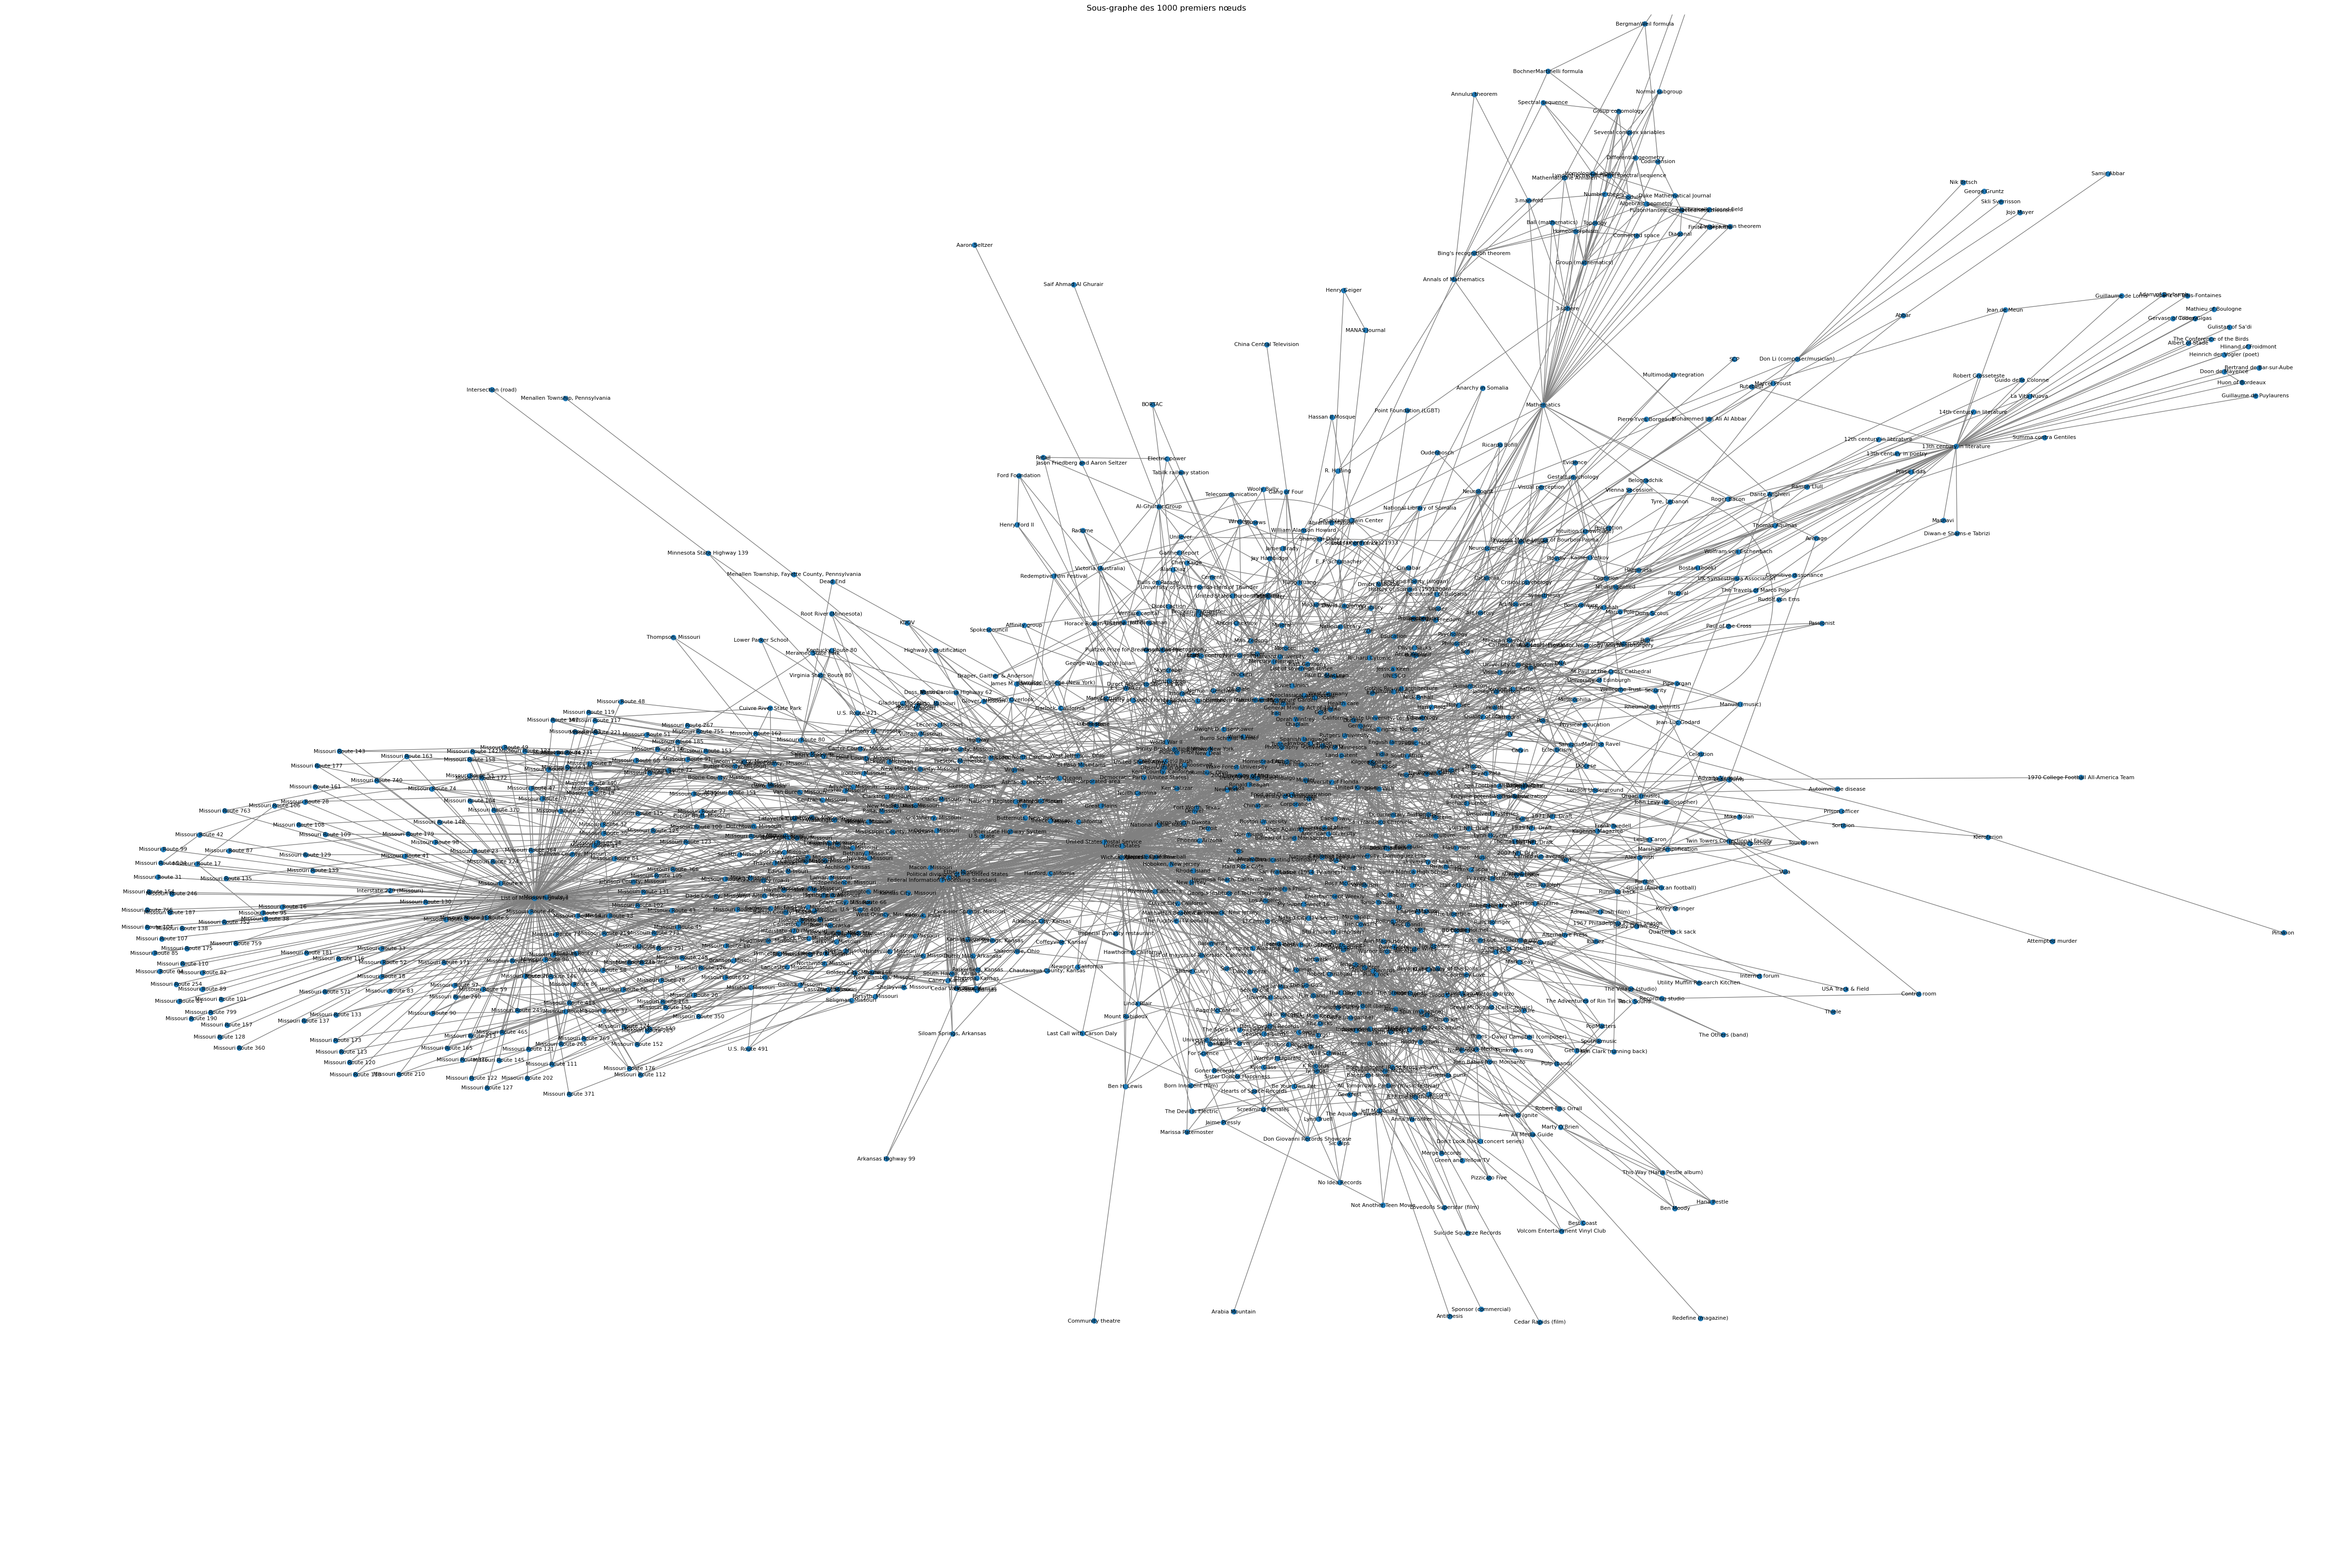

In [26]:
# Visualiser une sous-partie du graphe
subgraph = G.subgraph(list(G.nodes)[:1000])  # Prenez un sous-graphe avec 100 nœuds
pos = nx.spring_layout(subgraph, seed=42)  # Layout pour la visualisation

print(f"Nombre de nœuds : {subgraph.number_of_nodes()}")
print(f"Nombre d'arêtes : {subgraph.number_of_edges()}")


plt.figure(figsize=(48, 32))
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    labels={node: G.nodes[node]["name"] for node in subgraph.nodes},  # Utiliser les noms des pages
    node_size=50,
    font_size=8,
    edge_color="gray",
)

# Zoom sur une région spécifique en ajustant les axes (valeurs ajustées manuellement)
plt.xlim(-0.4, 0.4)  # Ajustez les valeurs pour cibler une région
plt.ylim(-0.4, 0.4)

plt.title("Sous-graphe des 1000 premiers nœuds")

# Sauvegarder en PDF
plt.savefig("sous_graphe_1000_nodes.pdf", format="pdf", bbox_inches="tight")

# Afficher le graphique
plt.show()

In [49]:
print(global_modularity(clusters[1.2], subgraph))

NetworkXError: nbunch is not a node or a sequence of nodes.